## 6.3 Geographic Visualization

### This script contains the following:

#### 1. Import data and libraries
#### 2. Data wrangling
#### 3. Data cleaning
#### 4. Plotting a choropleth

###  1. Import data and libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
import folium
import json

In [2]:
# This command propts matplotlib visuals to appear in the notebook 

%matplotlib inline

In [3]:
# Folder location string
path = r'C:\Users\nurgul\Linkedin'

In [4]:
import requests

url = "https://coach-courses-us.s3.amazonaws.com/public/courses/data-immersion/A6/6.3/us-states.json"
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Save the content to a local file
    with open("us-states.json", "wb") as f:
        f.write(response.content)
  

In [5]:
# Importing cleaned dataset
df = pd.read_csv('job_posts_clean_final.csv', index_col=False)

In [6]:
df.head()

,job_id,title,work_type,location,applies,views,experience_level,listed_time,approx_salary,name,company_size,state,zip_code,salary_category,applies_category,industry,grouped_industry
0,3757935001,Sales Manager,Full-time,"Coeur d'Alene, ID",18.329151,66.426309,Mid-Senior level,2023-11-04 06:40:00,237500.0,J. Galt,3.000000,Indiana,46268,high,medium,Financial Services,Financial Services
1,3757934319,Controls Engineer,Full-time,"Orlando, FL",1.000000,5.000000,Mid-Senior level,2023-11-04 06:40:00,135500.0,head-huntress.com,4.537178,CA,92025,high,low,Staffing and Recruiting,Staffing and Recruiting
2,3757934318,CDL Class B Driver,Full-time,"Oakland, CA",15.568389,56.874644,Mid-Senior level,2023-11-04 06:40:00,26.0,Conexwest,2.000000,California,94607,low,medium,Retail Office Equipment,Retail
3,3757934267,CDL A Delivery Driver,Full-time,"Swedesboro, NJ",15.568389,56.874644,Entry level,2023-11-04 06:40:00,95000.0,Core-Mark International,6.000000,Texas,76262,medium,medium,Wholesale,Wholesale
4,3757934264,Sales Manager,Full-time,"Richmond, VA",18.329151,66.426309,Mid-Senior level,2023-11-04 06:40:00,237500.0,J. Galt,3.000000,Indiana,46268,high,medium,Financial Services,Financial Services


In [7]:
df.shape

(6726, 17)

In [8]:
print(df.columns)

Index(['job_id', 'title', 'work_type', 'location', 'applies', 'views',
       'experience_level', 'listed_time', 'approx_salary', 'name',
       'company_size', 'state', 'zip_code', 'salary_category',
       'applies_category', 'industry', 'grouped_industry'],
      dtype='object')


### 2. Data wrangling

In [9]:
# Select only the necessary columns and put them in a list called columns

columns = ['zip_code','job_id',
"applies",
"views",
"grouped_industry",
]           

In [10]:
# Create a subset

state_rec = df[columns]

In [11]:
state_rec.head()

,zip_code,job_id,applies,views,grouped_industry
0,46268,3757935001,18.329151,66.426309,Financial Services
1,92025,3757934319,1.000000,5.000000,Staffing and Recruiting
2,94607,3757934318,15.568389,56.874644,Retail
3,76262,3757934267,15.568389,56.874644,Wholesale
4,46268,3757934264,18.329151,66.426309,Financial Services


In [12]:
# Check for missing values

state_rec.isnull().sum()

zip_code            0
job_id              0
applies             0
views               0
grouped_industry    0
dtype: int64

In [13]:
state_rec.shape

(6726, 5)

In [14]:
dups = state_rec.duplicated()

In [15]:
dups.shape # no dups

(6726,)

### Checking extreme values

/Users/nurgul/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='applies', ylabel='Count'>

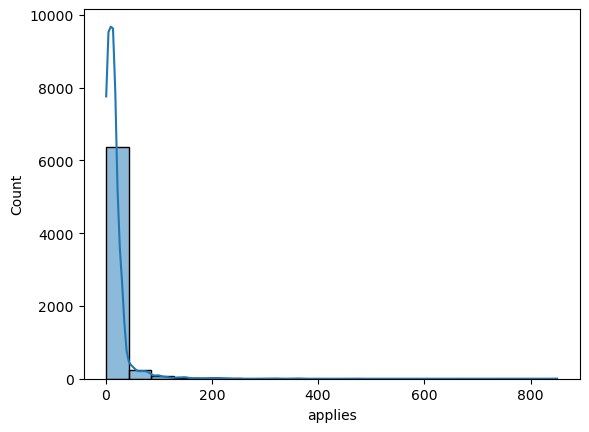

In [16]:
sns.histplot(state_rec['applies'], bins=20, kde = True) # shows extreme values for 'applies'

In [17]:
state_rec[state_rec['applies']>700]

,zip_code,job_id,applies,views,grouped_industry
1199,2114,3757481783,850.0,1599.0,Consulting and Business Services


In [18]:
state_rec=state_rec[state_rec['applies']<700]

/Users/nurgul/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='views', ylabel='Count'>

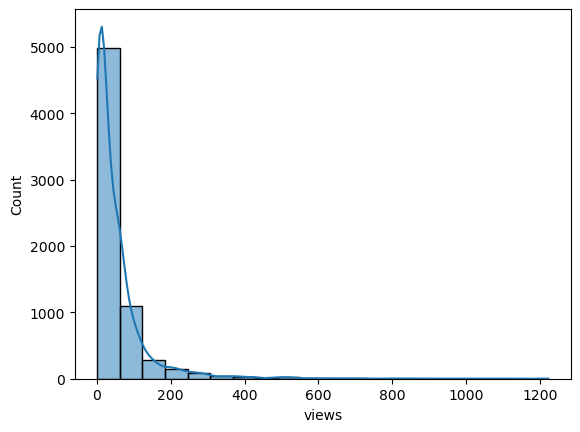

In [19]:
sns.histplot(state_rec['views'], bins=20, kde = True) # shows extreme values for 'views'

In [20]:
state_rec[state_rec['views']>1000]

,zip_code,job_id,applies,views,grouped_industry
1767,94401,3756925036,472.0,1132.0,Technology and IT
3896,90038,3701315028,311.0,1056.0,Entertainment
3910,80202,3701314621,188.0,1098.0,Apparel and Fashion
3976,94041,3701308803,300.0,1138.0,Technology and IT
4993,10577,3697383849,92.0,1223.0,Technology and IT
5952,0,3693070205,189.0,1026.0,Entertainment


In [21]:
state_rec=state_rec[state_rec['views']<1000]

In [22]:
state_rec.shape

(6719, 5)

In [ ]:
with open('us-states.json', 'r') as f:
    geo_data = f.read()
# Group by 'zip_code' and calculate the sum of 'applies'
applies_by_zip = state_rec.groupby('zip_code')['job_id'].size().reset_index()

# Create a folium map
map03 = folium.Map(location=[37, -97], zoom_start=3.5)

# Choropleth map
folium.Choropleth(
    geo_data=geo_data,
    data=sum_applies_by_zip,
    columns=['zip_code', 'job_id'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.75,
    line_opacity=0.1,
    nan_fill_color='white',
    legend_name="Sum of Applies by Zip Code"
).add_to(map03)

folium.LayerControl().add_to(map03)
map03



In [24]:
zip_applies_counts = state_rec.groupby(['zip_code', 'applies']).size().reset_index(name='counts')

# Create a folium map
map03 = folium.Map(location=[37, -97], zoom_start=3.5)

# Choropleth map
folium.Choropleth(
    geo_data=geo_data,
    data=zip_applies_counts,
    columns=['zip_code', 'applies', 'counts'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.75,
    line_opacity=0.1,
    nan_fill_color='white',
    legend_name="Applies Counts by Value"
).add_to(map03)

folium.LayerControl().add_to(map03)
map03